In [1]:
from formulae.terms.call_resolver import get_function_from_module
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
from bambi.backend.utils import get_distribution
from bambi.backend.utils import get_distribution_from_prior

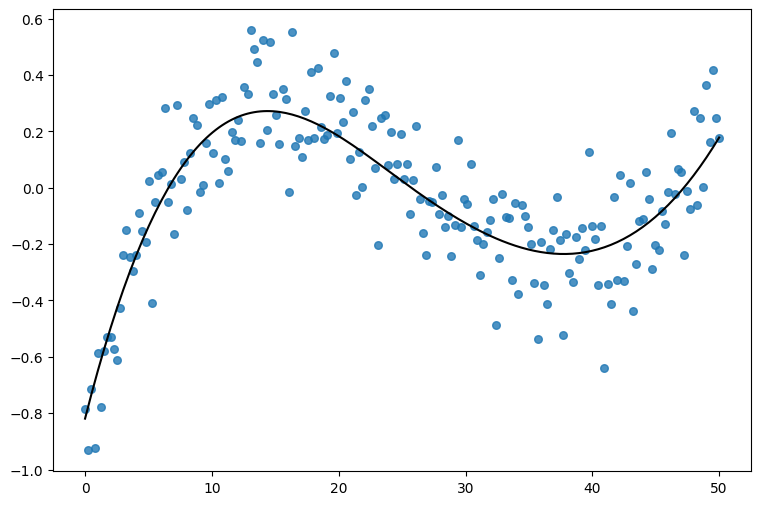

In [3]:
rng = np.random.default_rng(seed=121195)

N = 200
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=5)
sigma_t = 0.15

dm = design_matrices("0 + bs(x, df=5, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [5]:
m = [15]
df = pd.DataFrame({"x": x, "y": y})
dm = design_matrices("y ~ 1 + hsgp(x, m=m, c=2, centered=True)", df)

In [30]:
def build_hsgp(*x, m, L=None, c=None, by=None, cov="ExpQuad", drop_first=False, centered=False):
    print(x)
    print(m)
    return HSGP(*x, m=m, L=None, c=None, by=None, cov="ExpQuad", drop_first=False, centered=False)

class HSGP:
    def __new__(self, *x, m, L=None, c=None, by=None, cov="ExpQuad", drop_first=False, centered=False):
        self.by = by
        self.m = m
        self.L = L
        self.c = c
        self.by = by
        self.cov = cov
        self.drop_first = drop_first
        self.centered = centered
        self.data = np.column_stack(x)
        return self.data

hsgp = build_hsgp

In [36]:
import functools
import inspect

def hsgp(*x, m, L=None, c=None, by=None, cov="ExpQuad", drop_first=False, centered=False, _state=None):
    params = locals()
    params.pop("_state")
    params.pop("x")
    print(params)

hsgp([1, 2], m=5)

{'m': 5, 'L': None, 'c': None, 'by': None, 'cov': 'ExpQuad', 'drop_first': False, 'centered': False}


In [51]:
def outer(a, b):
    def inner(a, b):
        return a + b
    inner.__metadata__ = {"a": a, "b": b}
    return inner(a, b)

In [52]:
outer(1, 1)

2

In [43]:
def stateful_transform(func):
    params = list(inspect.signature(func).parameters)
    print(params)

    @functools.wraps(func)
    def wrapper(data, *args, _metadata=None, _state=None, **kwargs):

        _state = {} if _state is None else _state
        extra_params = {}
        if "_metadata" in params:
            extra_params["_metadata"] = _metadata

        if isinstance(data, dict):
            results = {}
            for key, datum in data.items():
                if isinstance(key, str) and key.startswith("__"):
                    results[key] = datum
                else:
                    statum = _state.get(key, {})
                    results[key] = wrapper(datum, *args, _state=statum, **extra_params, **kwargs)
                    if statum:
                        _state[key] = statum
            return results
        return func(data, *args, _state=_state, **extra_params, **kwargs)

@stateful_transform
def hsgp(*x, m, L=None, c=None, by=None, cov="ExpQuad", drop_first=False, centered=False, _state=None):
    params = locals()
    params.pop("_state")
    params.pop("x")

['x', 'm', 'L', 'c', 'by', 'cov', 'drop_first', 'centered', '_state']


In [44]:
def fun(x, a=None, b=1, c=2):
    fun.__metadata__ = {"a": a, "b": b, "c": c}
    return x

In [45]:
fun(1)

1

In [48]:
fun.__metadata__

{'a': 5, 'b': 1, 'c': 2}

In [47]:
fun(1, a=5)
fun.__metadata__

{'a': 5, 'b': 1, 'c': 2}

In [ ]:
import functools
import inspect

def stateful_transform(func):
    """
    Transform a callable object into a stateful transform.
    This is done by adding special arguments to the callable's signature:
    - _state: The existing state or an empty dictionary.
    - _metadata: Any extra metadata passed about the factor being evaluated.

    If the callable has any of these in its signature, these will be passed onto
    it; otherwise, they will be swallowed by the stateful transform wrapper.
    Stateful transforms are also transformed into single dispatches, allowing
    different implementations for incoming data types.
    """
    func = functools.singledispatch(func)
    params = inspect.signature(func).parameters.keys()

    @functools.wraps(func)
    def wrapper(data, *args, _metadata=None, _state=None, **kwargs):

        _state = {} if _state is None else _state
        extra_params = {}
        if "_metadata" in params:
            extra_params["_metadata"] = _metadata

        if isinstance(data, dict):
            results = {}
            for key, datum in data.items():
                if isinstance(key, str) and key.startswith("__"):
                    results[key] = datum
                else:
                    statum = _state.get(key, {})
                    results[key] = wrapper(
                        datum, *args, _state=statum, **extra_params, **kwargs
                    )
                    if statum:
                        _state[key] = statum
            return results
        return func(data, *args, _state=_state, **extra_params, **kwargs)

    wrapper.__is_stateful_transform__ = True
    return wrapper

In [22]:
hsgp()

<function __main__.build_hsgp(*x, m, L=None, c=None, by=None, cov='ExpQuad', drop_first=False, centered=False)>

In [17]:
hsgp([1, 2, 3], m=10)

array([[1],
       [2],
       [3]])

In [20]:
hsgp.__dict__

{'by': None,
 'm': 5,
 'L': None,
 'c': None,
 'cov': 'ExpQuad',
 'drop_first': False,
 'centered': False}

In [19]:
hsgp([1, 2, 3, 4], m=5)
hsgp.__dict__

{'by': None,
 'm': 5,
 'L': None,
 'c': None,
 'cov': 'ExpQuad',
 'drop_first': False,
 'centered': False}

In [37]:
def bmb_exp_quad(sigma, ell, input_dim=1):
    return sigma ** 2 * pm.gp.cov.ExpQuad(input_dim, ls=ell)

GP_KERNELS = {            
    "ExpQuad": {
        "fn": bmb_exp_quad,
        "params": ("sigma", "ell", "input_dim")
    },
}

In [38]:
class BackendHSGPTerm:
    def __init__(self, term):
        self.term = term
        self.coords = self.term.coords.copy()
        if self.coords and self.term.alias:
            self.coords[self.term.alias + "_dim"] = self.coords.pop(self.term.name + "_dim")

    def build(self):
        label = self.term.alias if self.term.alias else self.term.name

        # Build covariance function
        cov_func = self.get_cov_func()

        # Build GP
        gp = pm.gp.HSGP(
            m=self.term.m, 
            c=self.term.c, 
            L=self.term.L, 
            drop_first=self.term.drop_first, 
            cov_func=cov_func
        )

        # Get prior components
        # NOTE: See one dimension is added
        phi, sqrt_psd = gp.prior_components(self.term.data)

        # Build deterministic
        # TODO: Add more appropriate names to parameters
        # TODO: Add dims names
        if self.term.centered:
            coeffs = pm.Normal(f"{label}_coeffs", sigma=sqrt_psd)
            output = pm.Deterministic(label, phi @ coeffs)
        else:
            coeffs = pm.Normal(f"{label}_coeffs", size=sqrt_psd.size)
            output = pm.Deterministic(label, phi @ (coeffs * sqrt_psd))
        return output


    def get_cov_func(self):
        # Get the callable that creates the function
        create_cov_function = GP_KERNELS[self.term.cov]["fn"]
    
        # Build priors
        label = self.term.alias if self.term.alias else self.term.name
        priors = {}
        names = GP_KERNELS[self.term.cov]["params"]
        for name in names:
            prior = self.term.prior[name]
            if isinstance(prior, bmb.Prior):
                distribution = get_distribution_from_prior(prior)
                coef = distribution(f"{self.term.name}_{name}", **prior.args)
            else:
                coef = prior
            priors[name] = coef
        return create_cov_function(**priors)

In [39]:
prior = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1),
    "input_dim": 1
}

In [7]:
type(dm.common.terms["hsgp(x, m = m, c = 2, centered = True)"])

formulae.terms.terms.Term

In [40]:
fm_term = dm.common.terms["hsgp(x, m = m, c = 2, centered = True)"]
bmb_term = HSGPTerm(fm_term, prior=prior)
pymc_term = BackendHSGPTerm(bmb_term)

* $\phi$ is of shape $(n, m)$
* $\text{psd}$ is of shape $(m, )$
* $\beta$ is of shape $(m, )$
* $f$ is of shape $(n, )$

In [41]:
with pm.Model() as model:    
    f = pymc_term.build()
    sigma = pm.HalfNormal("sigma", sigma=10)
    pm.Normal("lik", mu=f, sigma=sigma, observed=df["y"])

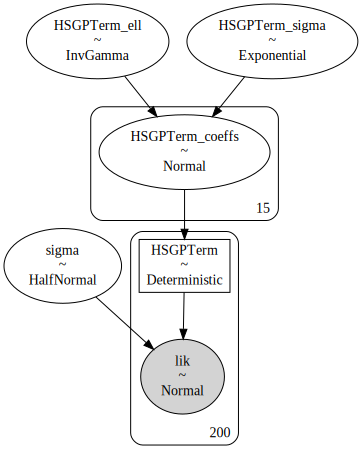

In [42]:
pm.model_to_graphviz(model)

In [47]:
with model:
    #idata = pm.sampling_jax.sample_numpyro_nuts(target_accept=0.8)
    idata = pm.sample()
print(idata.sample_stats.diverging.sum())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [HSGPTerm_sigma, HSGPTerm_ell, HSGPTerm_coeffs, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 64 seconds.


<xarray.DataArray 'diverging' ()>
array(0)


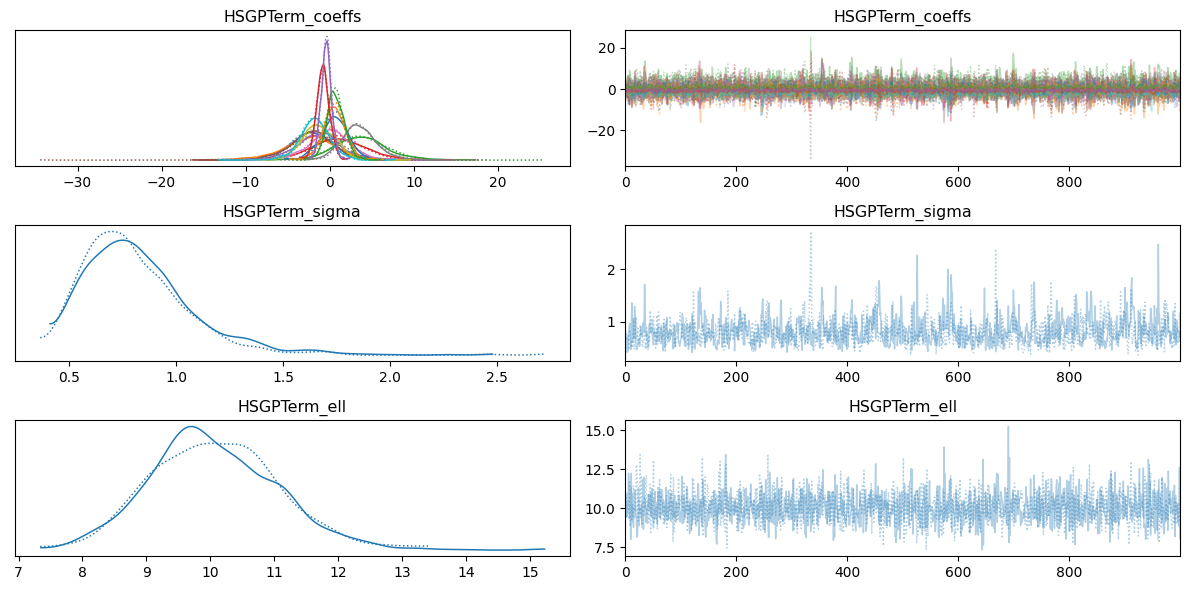

In [48]:
var_names = ["HSGPTerm_coeffs", "HSGPTerm_sigma", "HSGPTerm_ell"]
az.plot_trace(idata, var_names=var_names, backend_kwargs={"layout": "tight"});

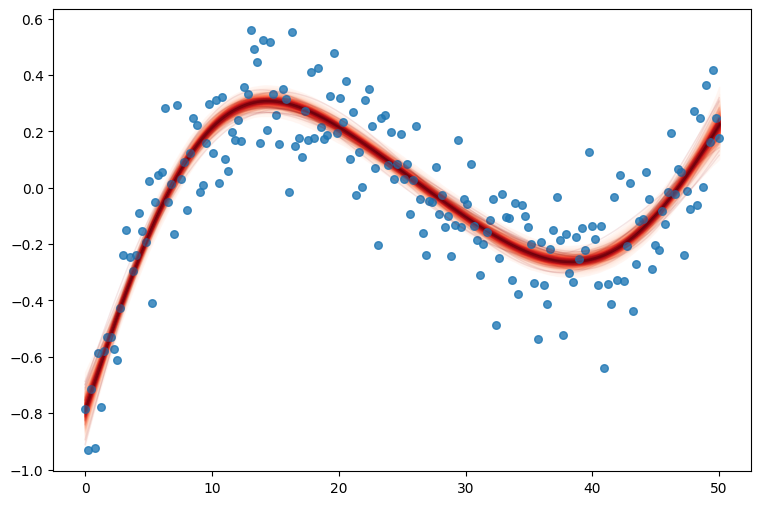

In [49]:
fig, ax = plt.subplots(figsize=(9, 6))
f = az.extract(idata, "posterior", var_names=["HSGPTerm"]) 
pm.gp.util.plot_gp_dist(ax, f.values.T, x)
ax.scatter(x, y, s=30, alpha=0.8);